In [27]:
import time
from copy import deepcopy

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np

import stg_energy.fig2_histograms.viz as viz
from pyloric.sbi_wrapper import get_time, simulate_energyscape
from stg_energy.common import col, svg
from stg_energy.fig2_histograms.energy import select_ss_close_to_obs

# Figure 2

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_C1 = "../svg/panel_c1.svg"
PANEL_C2 = "../svg/panel_c2.svg"
PANEL_D1 = "../svg/panel_d1.svg"
PANEL_D2 = "../svg/panel_d2.svg"

In [30]:
outfile = "../../results/11deg_post_pred/11_deg_post_pred.npz"
data_n = np.load(outfile)
sample_seeds = data_n["seeds"]
sample_params = data_n["params"]
sample_stats = data_n["stats"]
print("There are", len(sample_seeds), "datapoints in this dataset")

There are 1124507 datapoints in this dataset


In [31]:
print("sample_stats", sample_stats[0])

sample_stats [1.10367500e+03 1.70191667e+02 2.31752778e+02 3.93063889e+02
 2.85537500e+02 2.16906250e+01 4.57706250e+02 7.20062500e+02
 1.54204514e-01 2.09982810e-01 3.56140973e-01 2.58715201e-01
 1.96530908e-02 4.14711079e-01 6.52422588e-01 2.50000000e+00
 2.50000000e+00 2.50000000e+00 1.00231689e+04 2.64175050e+03
 1.79645902e+04 5.70620676e+05 3.72949451e+05 3.18997403e+06
 5.60000000e+01 1.37000000e+02 1.77000000e+02 9.00000000e+00
 9.00000000e+00 9.00000000e+00]


### Load prior simulations for getting the std and mean of summstats

In [32]:
datafile = "../../results/prior_samples_after_classifier/samples_full_3.npz"
data = np.load(datafile)

params = data["params"]
stats = data["stats"]
seeds = data["seeds"]

stats_mean = np.mean(stats, axis=0)
stats_std = np.std(stats, axis=0)

### Load experimental data

In [33]:
npz = np.load("../../results/experimental_data/summstats_prep845_082_0044.npz")
observation = npz["summ_stats"]

npz = np.load("../../results/experimental_data/trace_data_845_082_0044.npz")
t = npz["t"]

In [34]:
observation

array([1.17085859e+03, 2.06036434e+02, 2.14307031e+02, 4.12842187e+02,
       2.75164844e+02, 4.20460938e+01, 4.81925781e+02, 7.38278906e+02,
       1.75970382e-01, 1.83034085e-01, 3.52597820e-01, 2.35011166e-01,
       3.59104797e-02, 4.11600328e-01, 6.30544893e-01, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00])

### Select only the ones that are close to the observation

In [35]:
stats_std * 0.01

array([1.02627304e+01, 7.45749320e+00, 6.67399653e+00, 5.56057901e+00,
       3.74952141e+00, 7.03324819e+00, 8.31305524e+00, 8.90978283e+00,
       3.08293428e-03, 3.49053123e-03, 2.94070659e-03, 1.64757951e-03,
       3.17512674e-03, 1.93512987e-03, 2.08303979e-03, 2.95139748e-01,
       6.37143175e-01, 3.58698940e-01])

In [36]:
num_std = np.asarray(
    [0.02, 0.02, 0.02, 0.02, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
)

In [37]:
good_params, good_dat, good_seeds = select_ss_close_to_obs(
    sample_params,
    sample_stats,
    sample_seeds,
    observation,
    num_std=num_std,
    stats_std=stats_std[:15],
)

In [38]:
good_dat.shape

(55043, 30)

In [39]:
sample_stats = good_dat
sample_params = good_params
sample_seeds = good_seeds

In [40]:
# np.savez('../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz',
#         sample_stats=sample_stats, sample_params=sample_params, sample_seeds=sample_seeds)

# Panel A: Histogram for total energy

In [41]:
all_energies_per_spike = sample_stats[:, 18:21]
all_total_energies = sample_stats[:, 21:24]

In [42]:
summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


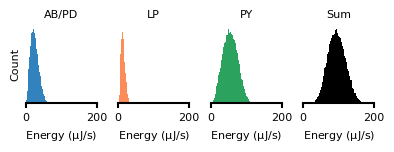

In [43]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 4, figsize=(4.5, 1))

    # The factor /4000 comes from: 0.025ms stepsize -> total energy = int_energy = energy * 0.025ms = energy / 40000
    # But then, we have x1000 because all our currents are given in /cm**2. Thus, we have to multiply with 10,000 to obtain nano-Joule.
    # We say that our units are in micro-Joule, hence divide by 1000.
    # Lastly, divide by 10 because 10 second recording
    # This gives us: /40000 * 10000 / 1000 / 10 = /40000
    _ = ax[0].hist(
        all_total_energies[:, 0] / 40000, range=[0, 200], bins=100, color="#3182bd"
    )
    ax[0].set_ylabel("Count")
    ax[0].tick_params(axis="both", which="major")
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["right"].set_visible(False)
    ax[0].spines["left"].set_visible(False)
    ax[0].axes.get_yaxis().set_ticks([])
    ax[0].set_title("AB/PD")

    _ = ax[1].hist(
        all_total_energies[:, 1] / 40000, range=[0, 200], bins=100, color="#fc8d59"
    )
    # ax[1].set_ylabel('Count')
    ax[1].tick_params(axis="both", which="major")
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    ax[1].axes.get_yaxis().set_ticks([])
    ax[1].set_title("LP")

    _ = ax[2].hist(
        all_total_energies[:, 2] / 40000, range=[0, 200], bins=100, color="#2ca25f"
    )
    # ax[2].set_ylabel('Count')
    ax[2].tick_params(axis="both", which="major")
    ax[2].spines["top"].set_visible(False)
    ax[2].spines["right"].set_visible(False)
    ax[2].spines["left"].set_visible(False)
    ax[2].axes.get_yaxis().set_ticks([])
    ax[2].set_title("PY")

    _ = ax[3].hist(summed_energies_total / 40000, range=[0, 200], bins=100, color="k")
    # ax[3].set_ylabel('Count')
    ax[3].tick_params(axis="both", which="major")
    ax[3].spines["top"].set_visible(False)
    ax[3].spines["right"].set_visible(False)
    ax[3].spines["left"].set_visible(False)
    ax[3].axes.get_yaxis().set_ticks([])
    ax[3].set_title("Sum")

    plt.subplots_adjust(wspace=0.3)
    
    for i in range(4):
        ax[i].set_xlim([0, 200])
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        ax[i].set_xlabel("Energy ($\mu$J/s)")
        ax[i].set_xticks([0, 200])

    plt.savefig(PANEL_A, facecolor="None", transparent=True)
    plt.show()

# Panel B: Histogram for energy per spike

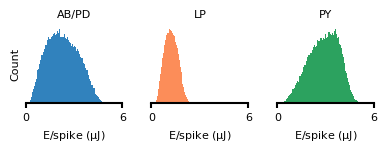

In [44]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(4.5, 1))

    # The factor /4000 comes from: 10 second recording. 0.025ms stepsize -> total energy = int_energy = energy * 0.025ms = energy / 40000
    _ = ax[0].hist(all_energies_per_spike[:, 0]/40000*10, range=[0, 6], bins=100, color="#3182bd")
    ax[0].set_ylabel("Count")
    ax[0].axes.get_yaxis().set_ticks([])
    ax[0].set_title("AB/PD")

    _ = ax[1].hist(
        all_energies_per_spike[:, 1]/40000*10, range=[0, 6], bins=100, color="#fc8d59"
    )
    # ax[1].set_ylabel('Count')
    ax[1].set_xlabel("E/spike")
    ax[1].axes.get_yaxis().set_ticks([])
    ax[1].set_title("LP")

    _ = ax[2].hist(all_energies_per_spike[:, 2]/40000*10, range=[0, 6], bins=100, color="#2ca25f")
    # ax[2].set_ylabel('Count')
    ax[2].set_xlabel("E/spike")
    ax[2].axes.get_yaxis().set_ticks([])
    ax[2].set_title("PY")

    for i in range(3):
        ax[i].set_xlim([0, 6])
        ax[i].set_xticks([0, 6])
        ax[i].set_xlabel("E/spike ($\mu$J)")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)

    plt.subplots_adjust(wspace=0.3)

    plt.savefig(PANEL_B, facecolor="None", transparent=True)
    plt.show()

# Panel C: trace with highest and lowest energy

In [45]:
inds = np.argsort(summed_energies_total)
sorted_params = sample_params[inds]
sorted_seeds = sample_seeds[inds]

In [46]:
all_out_targets = []

for counter in [0, len(sorted_params) - 1]:
    print("sorted_seeds[counter]", sorted_seeds[counter])
    out_target = simulate_energyscape(
        deepcopy(sorted_params[counter]), seed=sorted_seeds[counter]
    )
    all_out_targets.append(out_target)

sorted_seeds[counter] 7284523
sorted_seeds[counter] 465919


Showing :   3.0 seconds
Scalebar indicates:  50mV


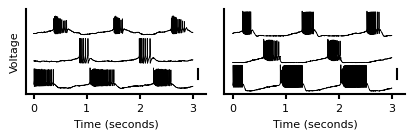

In [73]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.compare_voltage_low_and_high_energy_trace(
        all_out_targets,
        t,
        get_time(),
        figsize=(4.9, 1.1),
        cols=['k','k','k'],
    )
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

Showing :   3.0 seconds
Scalebar indicates:  1000 micro Joule / second


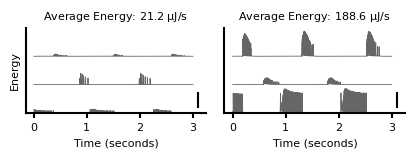

In [80]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.compare_energy_low_and_high_energy_trace(
        all_out_targets,
        t,
        get_time(),
        figsize=(4.9, 1.1),
        cols=['k','k','k'],
    )
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

# Panel D: Energy scape

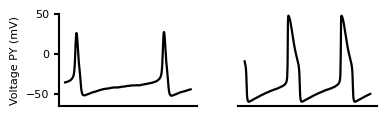

In [67]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_scape_voltage(
        all_out_targets,
        t,
        get_time(),
        figsize=(4.1, 1.2),
        cols=['k', 'k', 'k'],
    )
    plt.savefig(PANEL_D1, facecolor="None", transparent=True)
    plt.show()

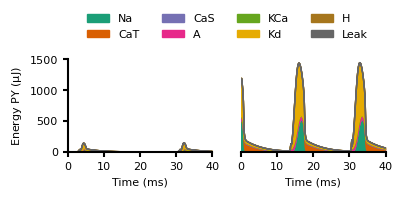

In [70]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_scape_energy(
        all_out_targets,
        t,
        get_time(),
        figsize=(4.1, 1.2),
        cols=col,
    )
    plt.savefig(PANEL_D2, facecolor="None", transparent=True)
    plt.show()

# Assemble figure

In [71]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [81]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "11.4cm",
    
    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
    
    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(0*factor_svg, 26.6*factor_svg),
    
    Panel(
          SVG(PANEL_D1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("b", -2*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(73*factor_svg, 0.0*factor_svg),
    
    Panel(
          SVG(PANEL_D2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(73*factor_svg, 20.0*factor_svg),
    
    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 55.0*factor_svg),
    
    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("d", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(73*factor_svg, 55.0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig2.svg")
svg('../fig/fig2.svg')

# Additional stuff


In [144]:
print(
    "Energy per spike:  min: ",
    np.min(summed_energies_per_spike),
    " max: ",
    np.max(summed_energies_per_spike),
    " ratio: ",
    np.max(summed_energies_per_spike) / np.min(summed_energies_per_spike),
)
print(
    "Energy total:      min: ",
    np.min(summed_energies_total),
    " max: ",
    np.max(summed_energies_total),
    " ratio: ",
    np.max(summed_energies_total) / np.min(summed_energies_total),
)

Energy per spike:  min:  6788.608130555542  max:  43919.740452343845  ratio:  6.4696237590531975
Energy total:      min:  848945.6118815772  max:  7542451.395313956  ratio:  8.884493057920514


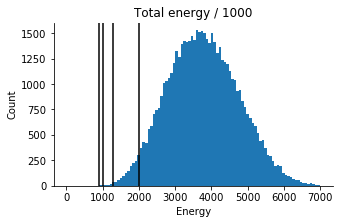

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

_ = ax.hist(summed_energies_total / 1000, range=[0, 7000], bins=100)
ax.set_ylabel("Count", fontsize=10.0)
ax.set_xlabel("Energy", fontsize=10.0)
ax.tick_params(axis="both", which="major", labelsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Total energy / 1000", fontsize=12.0)

ax.axvline(2000, color="k")
ax.axvline(1300, color="k")
ax.axvline(1000, color="k")
ax.axvline(900, color="k")

# plt.savefig('../results/energy/figs/hist_with_lines.pdf', bbox_inches='tight')